## Using skySampler with KinMS_fitter

Sometimes the objects you wish to fit have very asymmetric flux distributions that are not well fitted by simple analytic functions. In these cases you may wish to fix the flux distribution, and fit only the kinematics. The easy way this is done with KinMS is by using skySampler (originally written by Mark Smith: [link](https://github.com/Mark-D-Smith/KinMS-skySampler)), which as of v0.5.2 has been bundled with KinMS_fitter.

### Philosophy

Behind the scenes KinMS creates a cloud of point-source "cloudlets" that it then manipulates to describe the gas distribution. In the standard modes these are drawn from analytic functions (e.g. an exponential disc). 

There is no reason, however, why the user cannot supply these cloudlets themselves, to match any arbitary flux distribution. skySampler helps with this task, drawing cloudlets from an observed distribution.

### Usage

The code can create these cloudlets from a datacube, or moment zero map. The only requirement is the fits file has 2 or 3 dimensions, and ideally contains the CDELT1 or CD1_1 keyword to determine the (spatial) pixel size automatically (although this can be overridden). 

I would recommend using a masked moment0/cube in skySampler, only modelling the flux you are sure is real. 


Below I show an example of modelling a galaxy with strong spiral arms using KinMS_fitter and skySampler.

In [1]:
import numpy as np
from kinms_fitter import kinms_fitter
from kinms_fitter import skySampler
from kinms_fitter.velocity_profs import velocity_profs  

cube="NGC1386.co.image.fits"
mom0="NGC1386_mom0.fits"
mom2f="NGC1386_mom2.fits"

### Weighting

The code has two default weighting modes "uniform" and "intensity weighted". You can also use custom weightings. Its worth experimenting with these to see what works better for your problem. 

For uniform weighting one should set `sampFact` to some value (default 20). This sets the number of cloudlets created from each pixel of the input image. 


In [2]:
inClouds_uniform=skySampler(mom0).sample(sampFact=25)

Using a  uniform  scheme to sample with  348100  clouds.


Intensity weighted instead requires the `nSamps` keyword, setting the total number of samples to create, which it will do in a way thats weighted by the intensity of the emission. Brighter regions will be represented by more cloudlets. 

In [3]:
inClouds_intensity=skySampler(mom0).sample(nSamps=2e5)

Using a  Intensity-weighted  scheme to sample with  198455.0  clouds.


You may also set an alternative weighting (for instance, setting areas with a higher velocity dispersion to have more cloudlets). To enable this mode supply `nSamps`, and pass an image/cube of weights to `weighting`.

In [4]:
### read in alternate weighting
from astropy.io import fits
mom2=fits.open(mom2f)[0].data

### use it
inClouds_custom=skySampler(mom0).sample(nSamps=2e5,weighting=mom2)

Using a  custom weighting  scheme to sample with  198433.0  clouds.


### Running

Now you can run the code as normal, passing these cloudlets to `skySampClouds` and not inputing any surface brightness distribution!

*Note: I would NOT recommend running KinMS in a notebook like this for production code. Scripts are much more robust and reliable.*

==============   Welcome to KinMS_fitter!   ==============

        ██╗  ██╗██╗███╗   ██╗███╗   ███╗███████╗
        ██║ ██╔╝██║████╗  ██║████╗ ████║██╔════╝
        █████╔╝ ██║██╔██╗ ██║██╔████╔██║███████╗
        ██╔═██╗ ██║██║╚██╗██║██║╚██╔╝██║╚════██║
        ██║  ██╗██║██║ ╚████║██║ ╚═╝ ██║███████║
        ╚═╝  ╚═╝╚═╝╚═╝  ╚═══╝╚═╝     ╚═╝╚══════╝
        
One model evaluation takes 0.21 seconds


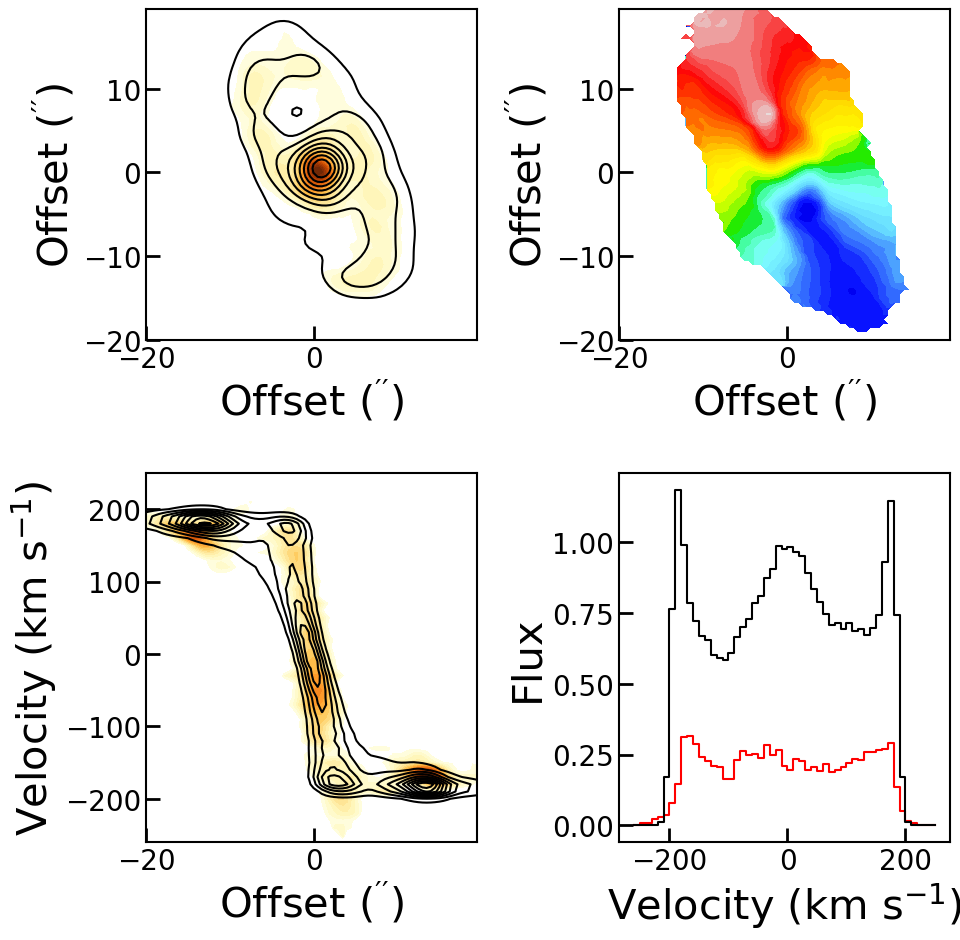

==============  Begin MCMC fitting process  ==============
Parameters Fixed: []
Correction for chi-sqr variance applied: 15.020919161132035
Doing chain 1
     Chain 0 has not converged - Accept rate: 0.08444444444444445
     Chain 0 has not converged - Accept rate: 0.18444444444444444
     --> Still varying: ['veldisp']
Chain 0 converged: LL: -1007.9868342279901 - Accept rate:0.3888888888888889
Best chain so far!
Best fit:
  Xc: -0.29276619227612644
  Yc: 2.2075549963541055
  Vsys: 879.7170577512243
  totflux: 85.07246795981283
  veldisp: 9.959774736783183
  PA: 24.41467202453786
  inc: 67.94920412604323
  Vmax: 191.6147227618086
  Rturn: 0.09431234015657557
Starting final chain


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
100%|█████████▉| 9989/9996 [06:55<00:00, 24.05it/s]
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:  7.0min finished


Final best fit values and 1sigma errors:
  Xc: -0.3395397922160904 + 0.06715351028408689 - 0.07623223195501816
  Yc: 2.132078310582928 + 0.176451199701118 - 0.15432381377956172
  Vsys: 879.8157043942863 ± 0.7379616726893232
  totflux: 87.05964204355226 + 2.419217254791704 - 1.5870802264754076
  veldisp: 10.52071201418826 + 0.6183388173628206 - 0.9014936433505305
  PA: 24.589067569913944 ± 0.320742084416505
  inc: 67.85670492362252 + 0.36725319158593095 - 0.4275090811242279
  Vmax: 191.37926380669484 ± 0.9349174812716399
  Rturn: 0.0852999336841283 + 0.06663020928615307 - 0.04762954878121703
MCMC fitting process took 701.53 seconds


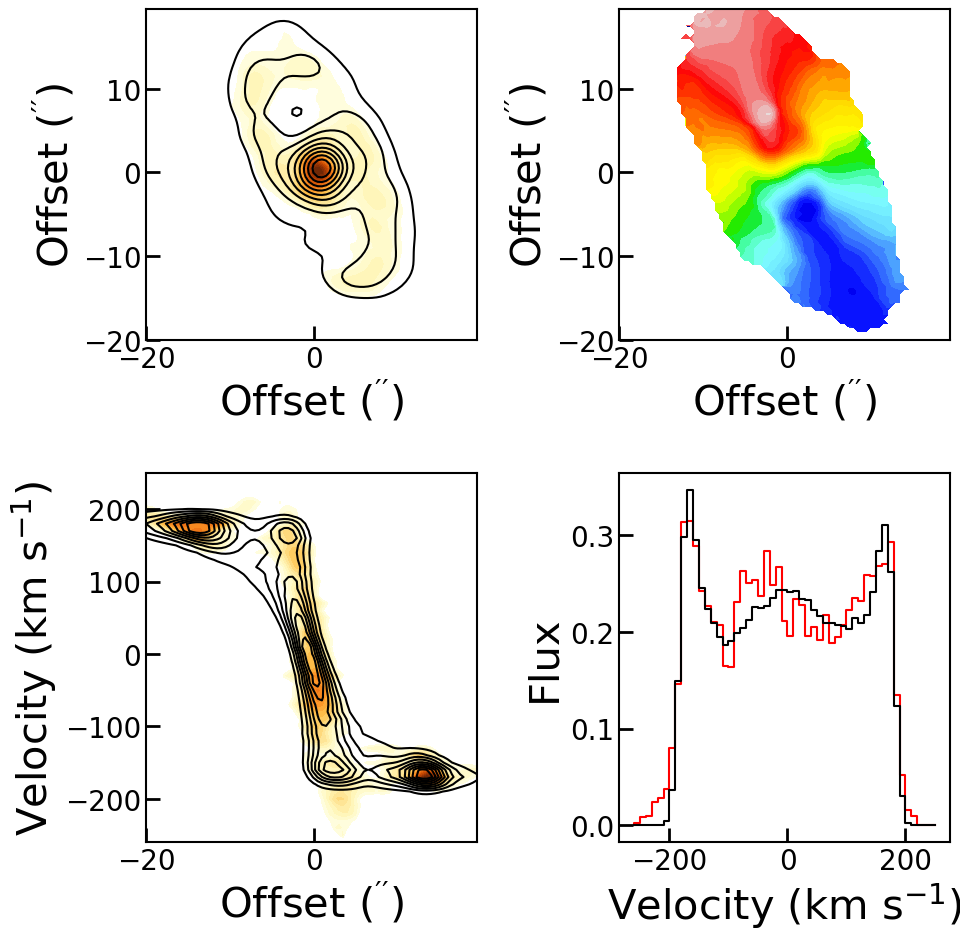

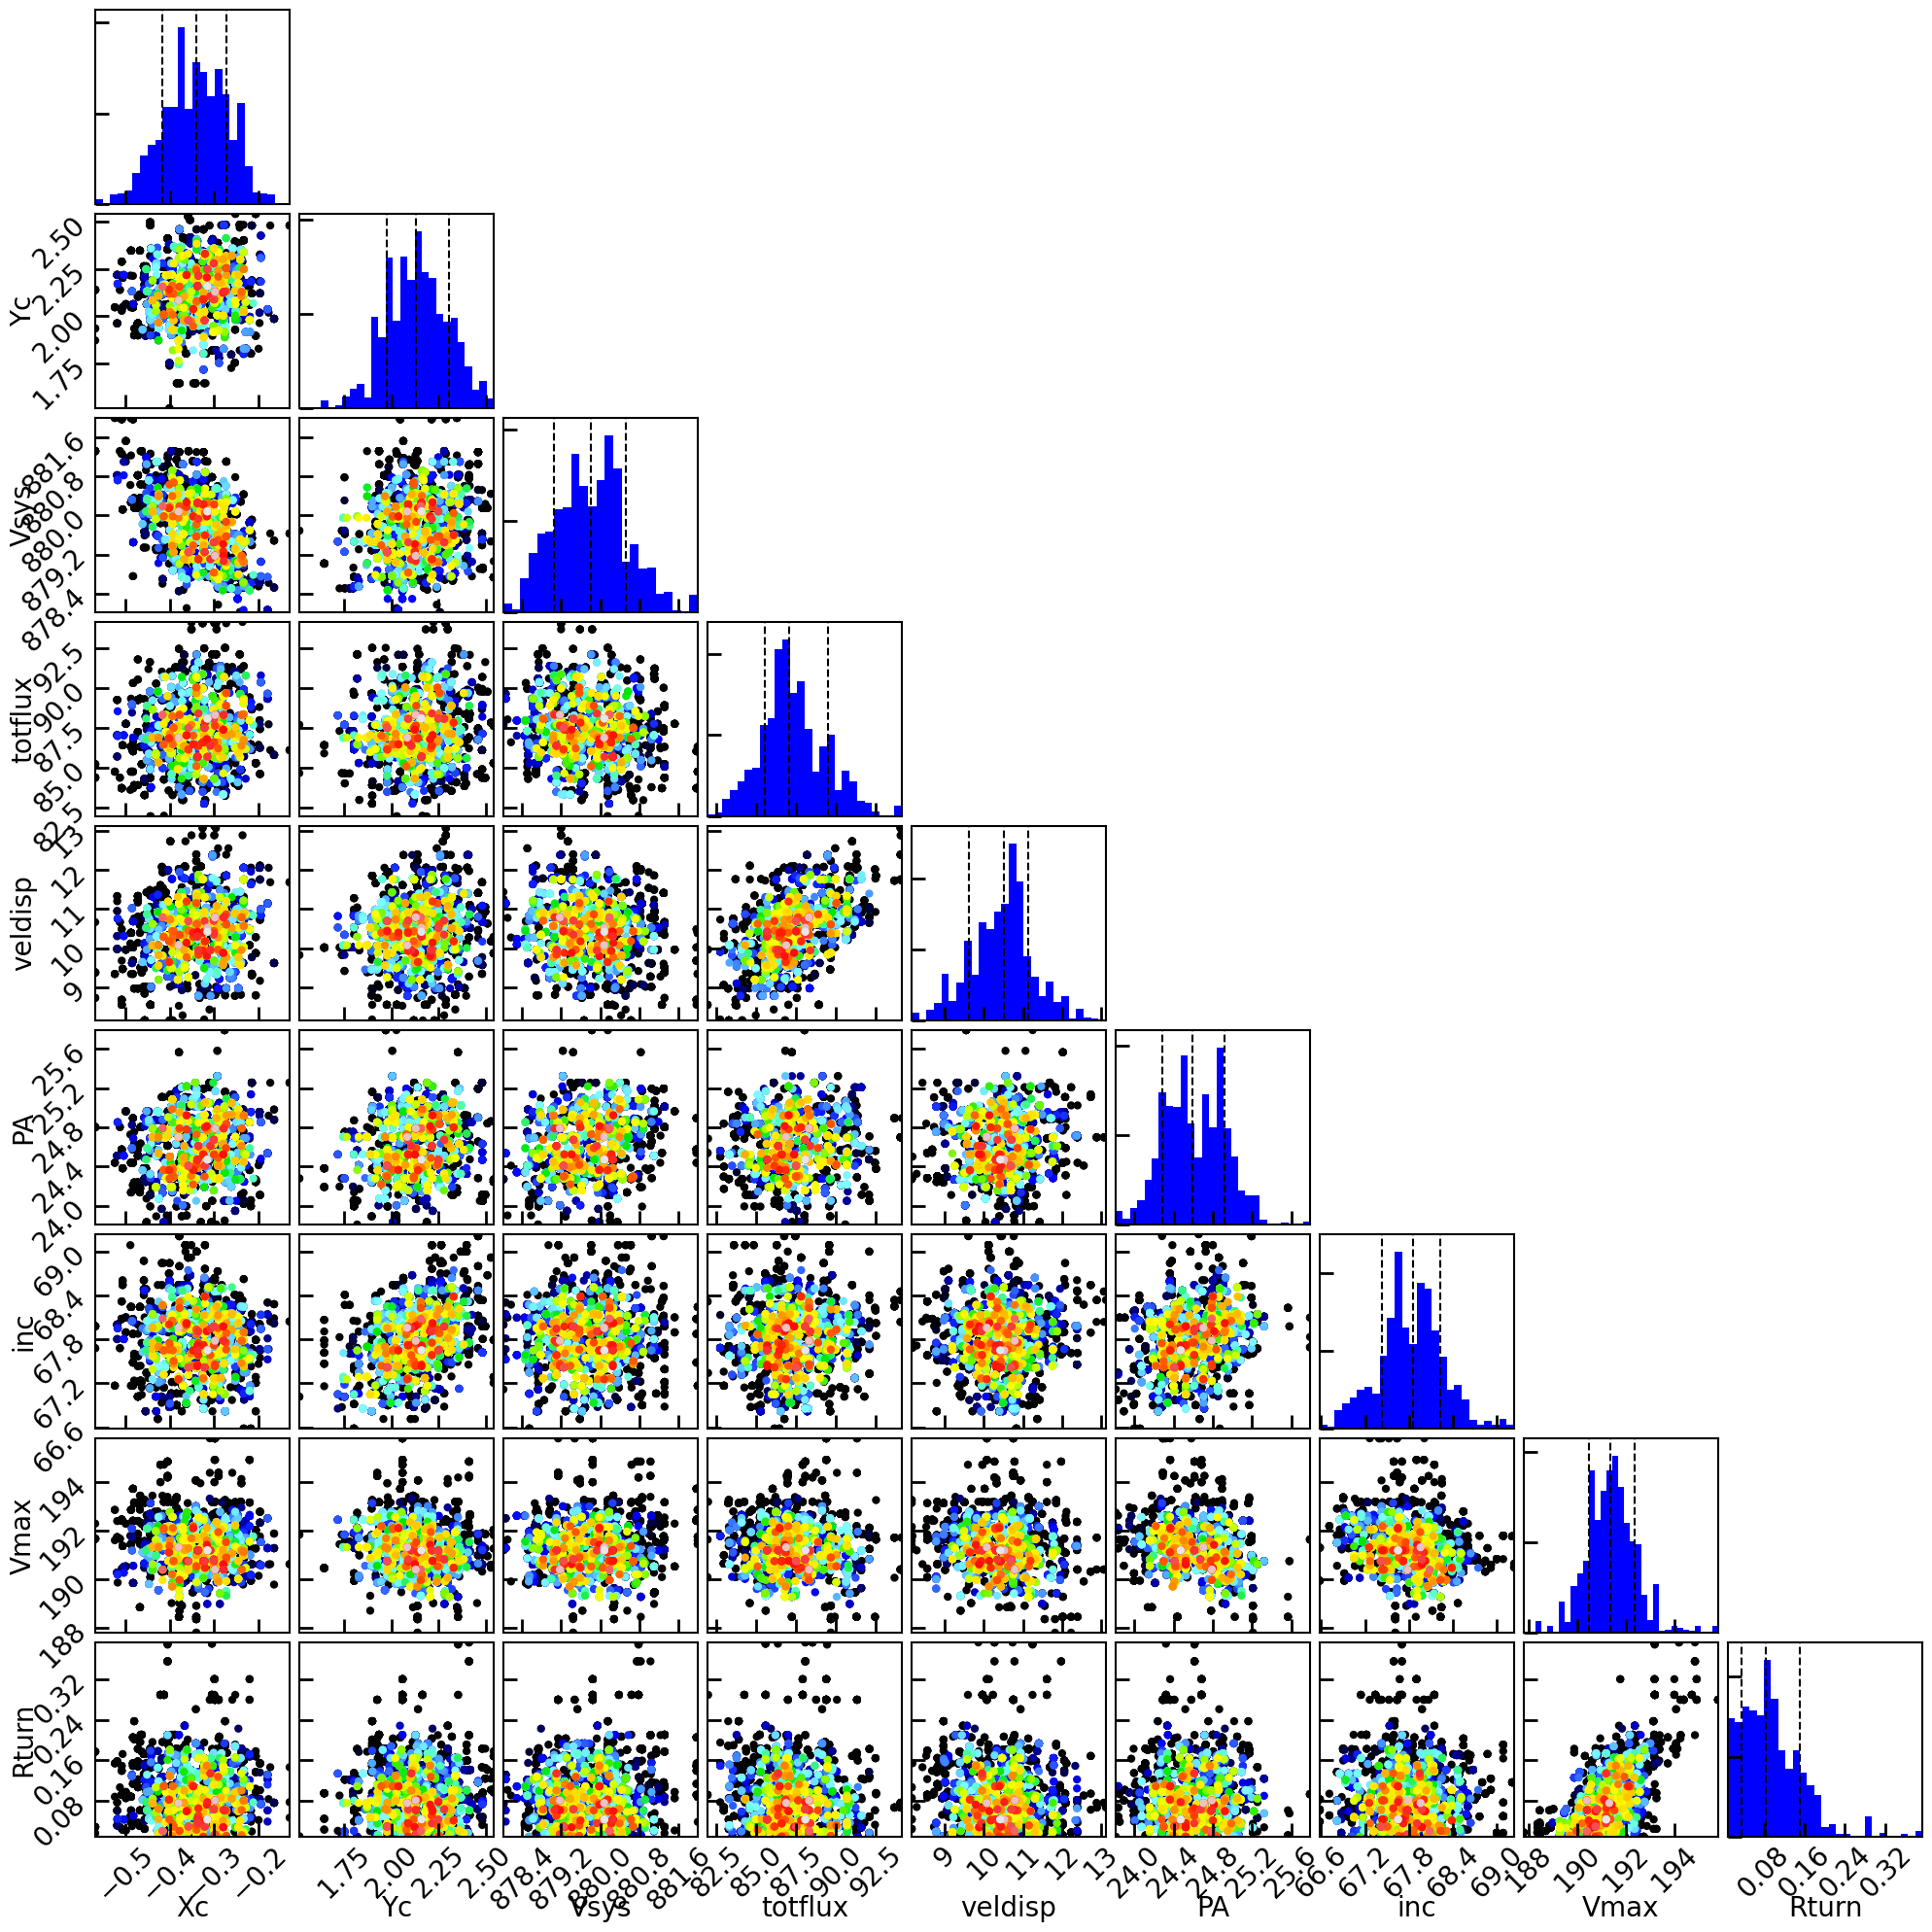

In [6]:
fv=kinms_fitter(cube,spatial_trim=[128-40,128+40,128-40,128+40],spectral_trim=[22,74])
fv.skySampClouds=inClouds_intensity ##input the cloudlets. Here I am using intensity weighting. 
fv.pa_guess=30
fv.inc_guess=70
fv.vel_profile=[velocity_profs.arctan(guesses=np.array([200,0.1]),minimums=np.array([50,0.01]),maximums=[410,10])]
fv.niters=10000

bestvals, besterrs, outputvalue, outputll,fixed = fv.run(method='mcmc')

As you can see we get a nice fit, despite having removed the surface brightness parameters from consideration!